# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


### Drop Recon Fields

In [3]:
churn.drop(['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH','RECON_EMAIL_NEXT_MTH'],inplace=True, axis=1)
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


### Data Exploration

In [4]:
churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


In [5]:
churn.dtypes

CUST_ID                           int64
ACCOUNT_TENURE                    int64
ACCT_CNT_SERVICES                 int64
AGE                             float64
CFU                              object
SERVICE_TENURE                    int64
PLAN_ACCESS_FEE                 float64
BYO_PLAN_STATUS                  object
PLAN_TENURE                       int64
MONTHS_OF_CONTRACT_REMAINING      int64
LAST_FX_CONTRACT_DURATION         int64
CONTRACT_STATUS                  object
PREV_CONTRACT_DURATION            int64
HANDSET_USED_BRAND               object
CHURN_IND                         int64
MONTHLY_SPEND                   float64
COUNTRY_METRO_REGION             object
STATE                            object
dtype: object

Must convert CFU, BYO_PLAN_STATUS, CONTRACT_STATUS, HANDSET_USED_BRAND, COUNTRY_METRO_REGION and STATE to integers to be used in the logistic regression model. Use one hot encoding to convert the categories to discrete values.

In [6]:
churn['CHURN_IND'].value_counts()

0    28416
1    17790
Name: CHURN_IND, dtype: int64

This dataset is not balanced as there is a very large difference in the amount of recorded data for each output

In [7]:
churn['CFU'].value_counts()

CONSUMER          39087
SMALL BUSINESS     7119
Name: CFU, dtype: int64

In [8]:
churn['CONTRACT_STATUS'].value_counts()

ON-CONTRACT     28281
OFF-CONTRACT    12460
NO-CONTRACT      5465
Name: CONTRACT_STATUS, dtype: int64

In [9]:
churn['ACCT_CNT_SERVICES'].value_counts()

1    28838
2    11174
3     4079
4     2115
Name: ACCT_CNT_SERVICES, dtype: int64

In [10]:
churn['MONTHS_OF_CONTRACT_REMAINING'].unique()

array([ 0, 13, 12, 11, 15,  4, 20, 21,  1,  8, 16,  3,  7, 17, 10, 23, 18,
       24,  2,  6, 22,  9, 19,  5, 14], dtype=int64)

In [11]:
churn['LAST_FX_CONTRACT_DURATION'].unique()

array([24, 12,  0, 36], dtype=int64)

In [12]:
churn['HANDSET_USED_BRAND'].value_counts()

APPLE      24805
SAMSUNG    13439
GOOGLE      2536
UNKNOWN     2300
OTHER       1796
HUAWEI      1330
Name: HANDSET_USED_BRAND, dtype: int64

In [13]:
churn['PLAN_ACCESS_FEE'].unique()

array([ 54.54,  40.9 ,  31.81,  90.9 ,  71.81,  72.72,  22.72,  36.36,
        45.45,  80.9 ,  45.44,  27.27,  53.63,  44.54,  54.53, 118.18,
        90.  ,  17.27,  30.9 ,  63.63,   8.18, 122.72,  36.35, 117.27,
        35.45, 180.  ,  59.08,  53.64,  62.72,  50.  ,  26.36,  71.82,
        59.09,  22.73,  31.82, 234.54, 107.26])

In [14]:
churn['PREV_CONTRACT_DURATION'].unique()

array([24, 12,  0, 36], dtype=int64)

#### Summary
- Majority are consumers rather than small businesses
- Most users using a service have an 'on-contract' status
- Most users have only 1 service under their account. As the number of services increase, there are fewer accounts with that number of services
- Majority of users own an Apple. This is followed by Samsung

In [15]:
churn.corr()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
CUST_ID,1.000000,0.080714,0.029416,0.064726,0.079962,0.017623,-0.061941,0.116875,0.037407,0.034723,-0.496335,-0.086179
ACCOUNT_TENURE,0.080714,1.000000,0.196271,0.250492,0.791784,-0.085160,0.247583,-0.170644,0.176972,0.503690,-0.151654,-0.137805
ACCT_CNT_SERVICES,0.029416,0.196271,1.000000,0.157515,0.068398,-0.003269,-0.041421,0.023829,0.001411,0.021421,-0.062390,-0.018687
AGE,0.064726,0.250492,0.157515,1.000000,0.251711,-0.347069,0.053575,-0.185477,-0.143253,0.008388,-0.115258,-0.209331
SERVICE_TENURE,0.079962,0.791784,0.068398,0.251711,1.000000,-0.078520,0.218260,-0.143886,0.139710,0.410986,-0.153512,-0.115622
PLAN_ACCESS_FEE,0.017623,-0.085160,-0.003269,-0.347069,-0.078520,1.000000,-0.058190,0.470779,0.393517,0.135970,-0.036587,0.448051
PLAN_TENURE,-0.061941,0.247583,-0.041421,0.053575,0.218260,-0.058190,1.000000,-0.429791,0.126140,0.184189,0.141586,-0.058206
MONTHS_OF_CONTRACT_REMAINING,0.116875,-0.170644,0.023829,-0.185477,-0.143886,0.470779,-0.429791,1.000000,0.424067,-0.009699,-0.247269,0.302084
LAST_FX_CONTRACT_DURATION,0.037407,0.176972,0.001411,-0.143253,0.139710,0.393517,0.126140,0.424067,1.000000,0.521020,-0.066734,0.218200
PREV_CONTRACT_DURATION,0.034723,0.503690,0.021421,0.008388,0.410986,0.135970,0.184189,-0.009699,0.521020,1.000000,-0.064199,-0.010426


<AxesSubplot:xlabel='ACCOUNT_TENURE', ylabel='Count'>

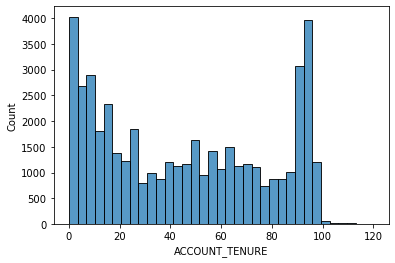

In [16]:
sns.histplot(x='ACCOUNT_TENURE',data=churn)

<AxesSubplot:xlabel='AGE', ylabel='Count'>

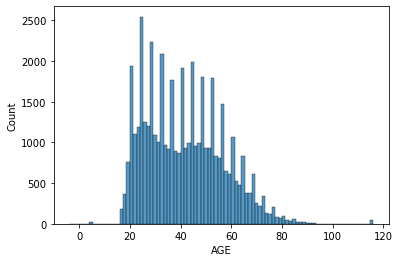

In [17]:
sns.histplot(x='AGE',data=churn)

<AxesSubplot:xlabel='SERVICE_TENURE', ylabel='Count'>

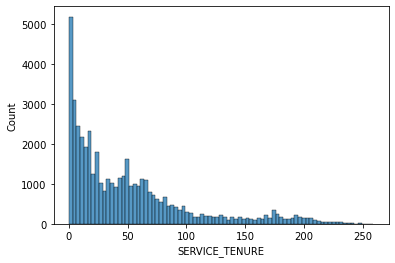

In [18]:
sns.histplot(x='SERVICE_TENURE',data=churn)

<AxesSubplot:xlabel='PLAN_ACCESS_FEE', ylabel='Count'>

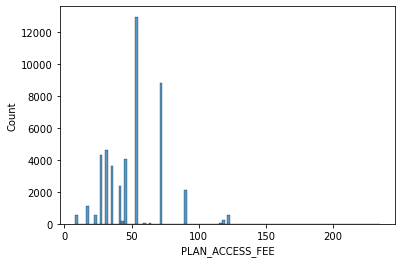

In [19]:
sns.histplot(x='PLAN_ACCESS_FEE',data=churn)

<AxesSubplot:xlabel='PLAN_TENURE', ylabel='Count'>

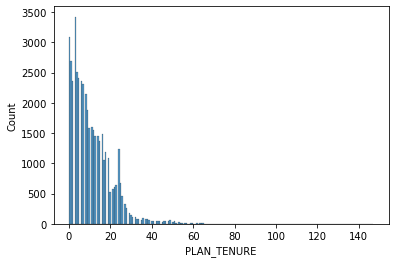

In [20]:
sns.histplot(x='PLAN_TENURE',data=churn)

<AxesSubplot:xlabel='MONTHS_OF_CONTRACT_REMAINING', ylabel='Count'>

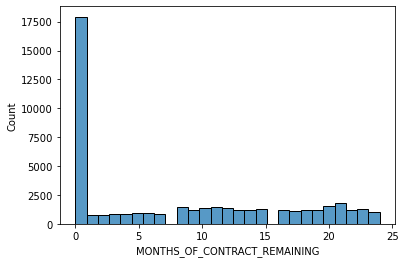

In [21]:
sns.histplot(x='MONTHS_OF_CONTRACT_REMAINING',data=churn)

<AxesSubplot:xlabel='MONTHLY_SPEND', ylabel='Count'>

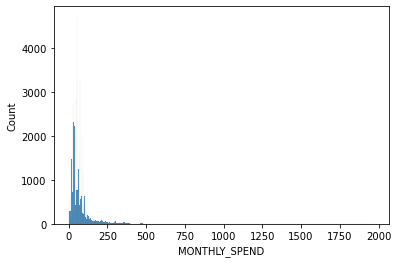

In [22]:
sns.histplot(x='MONTHLY_SPEND',data=churn)

<AxesSubplot:xlabel='AGE', ylabel='MONTHLY_SPEND'>

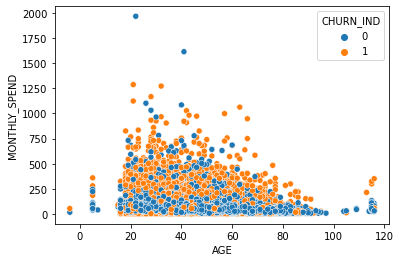

In [46]:
sns.scatterplot(x='AGE',y='MONTHLY_SPEND', hue = 'CHURN_IND', data=churn)

#### Summary
- Majority of users are younger. As the age increasess, the fewer users there are
- Majority of users don't have very long before their contract ends
- The fewer the months of tenure, the more users there are for plan tenure and service tenure

### Data Cleaning

In [24]:
churn.isnull().values.any()

True

<AxesSubplot:ylabel='INDEX'>

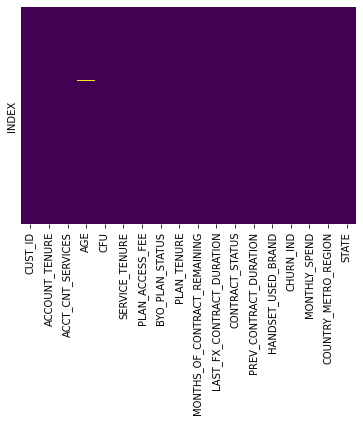

In [25]:
sns.heatmap(churn.isnull(), yticklabels=False, cbar = False, cmap = 'viridis')

In [26]:
#Fill missing age values with median
median = churn['AGE'].median()
churn['AGE'] = churn['AGE'].fillna(median)

In [27]:
churn.isnull().values.any()

True

<AxesSubplot:ylabel='INDEX'>

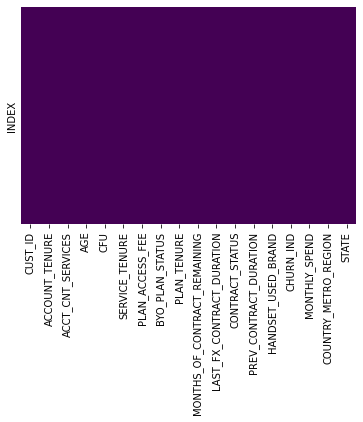

In [28]:
sns.heatmap(churn.isnull(), yticklabels=False, cbar = False, cmap = 'viridis')

The missing age values are replaced by the median age

In [29]:
nan_indice = np.where(churn.isna().any(1).values)
nan_indice

(array([23118], dtype=int64),)

In [30]:
churn.iloc[nan_indice]

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
23119,43285,94,1,52.0,CONSUMER,194,72.72,NON BYO,3,21,24,ON-CONTRACT,24,APPLE,0,72.72,NaN,NaN


In [31]:
#Drop a single row containing missing state and country_metro values
churn.dropna()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46202,79494,10,1,61.0,CONSUMER,9,27.27,BYO,7,0,0,NO-CONTRACT,0,OTHER,0,27.27,COUNTRY,VIC
46203,79495,2,1,53.0,CONSUMER,2,54.54,NON BYO,2,0,24,OFF-CONTRACT,24,UNKNOWN,1,54.99,METRO,NSW
46204,79496,47,1,22.0,CONSUMER,47,72.72,NON BYO,7,17,24,ON-CONTRACT,24,APPLE,0,72.72,COUNTRY,NSW


Located and dropped the row containing missing country_metro and state value

### One Hot Encoding

In [32]:
CFU = pd.get_dummies(churn['CFU'],drop_first=True)
BYO_PLAN_STATUS = pd.get_dummies(churn['BYO_PLAN_STATUS'],drop_first=True)
CONTRACT_STATUS = pd.get_dummies(churn['CONTRACT_STATUS'],drop_first=True)
HANDSET_USED_BRAND = pd.get_dummies(churn['HANDSET_USED_BRAND'],drop_first=True)
COUNTRY_METRO_REGION = pd.get_dummies(churn['COUNTRY_METRO_REGION'],drop_first=True)
STATE = pd.get_dummies(churn['STATE'],drop_first=True)

In [33]:
churn.drop(['CFU','BYO_PLAN_STATUS','CONTRACT_STATUS','HANDSET_USED_BRAND','COUNTRY_METRO_REGION','STATE'],axis=1,inplace=True)

In [34]:
churn = pd.concat([churn, CFU, BYO_PLAN_STATUS, CONTRACT_STATUS, HANDSET_USED_BRAND, COUNTRY_METRO_REGION, STATE], axis=1)
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,...,SAMSUNG,UNKNOWN,METRO,NSW,NT,QLD,SA,TAS,VIC,WA
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,46,54.54,15,0,24,24,...,1,0,0,0,0,0,0,0,0,1
2,2,60,3,55.0,59,54.54,5,0,24,24,...,0,0,1,1,0,0,0,0,0,0
3,5,65,1,29.0,65,40.90,15,0,12,12,...,0,0,0,0,0,0,0,0,0,1
4,6,31,1,51.0,31,31.81,31,0,24,24,...,0,0,0,0,0,0,0,0,1,0
5,8,95,1,31.0,95,54.54,0,0,24,24,...,0,0,1,1,0,0,0,0,0,0


Split the categorical features up into multiple columns containing 1s and 0s using pd.get_dummies. By doing this, the categorical features can now be displayed numerically, thus allowing us to use it in the logistic regression model

In [35]:
churn.corr()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,...,SAMSUNG,UNKNOWN,METRO,NSW,NT,QLD,SA,TAS,VIC,WA
CUST_ID,1.000000,0.080714,0.029416,0.064690,0.079962,0.017623,-0.061941,0.116875,0.037407,0.034723,...,0.007686,-0.043913,0.028845,0.004418,0.000425,-0.012426,0.007894,-0.006538,0.006596,-0.007138
ACCOUNT_TENURE,0.080714,1.000000,0.196271,0.250290,0.791784,-0.085160,0.247583,-0.170644,0.176972,0.503690,...,0.006940,-0.162830,0.029044,0.010450,-0.001115,-0.003906,0.019857,-0.035744,0.008893,-0.035806
ACCT_CNT_SERVICES,0.029416,0.196271,1.000000,0.157016,0.068398,-0.003269,-0.041421,0.023829,0.001411,0.021421,...,-0.016948,0.031666,0.016620,0.001942,-0.011231,0.006400,0.014052,-0.005729,-0.009204,-0.003279
AGE,0.064690,0.250290,0.157016,1.000000,0.251691,-0.346785,0.053583,-0.185313,-0.143096,0.008407,...,0.052901,-0.026386,0.030101,0.018057,-0.009574,-0.020487,0.018375,0.003862,0.002111,-0.017795
SERVICE_TENURE,0.079962,0.791784,0.068398,0.251691,1.000000,-0.078520,0.218260,-0.143886,0.139710,0.410986,...,0.024862,-0.186240,0.034568,0.006361,-0.004328,-0.007227,0.028220,-0.028925,0.004975,-0.031174
PLAN_ACCESS_FEE,0.017623,-0.085160,-0.003269,-0.346785,-0.078520,1.000000,-0.058190,0.470779,0.393517,0.135970,...,-0.038680,-0.044831,-0.043345,0.013555,0.011558,0.010920,-0.020630,-0.004536,-0.013808,0.006787
PLAN_TENURE,-0.061941,0.247583,-0.041421,0.053583,0.218260,-0.058190,1.000000,-0.429791,0.126140,0.184189,...,0.014390,-0.123628,-0.024393,0.002922,0.001861,-0.000424,0.002157,-0.006700,-0.008402,0.001118
MONTHS_OF_CONTRACT_REMAINING,0.116875,-0.170644,0.023829,-0.185313,-0.143886,0.470779,-0.429791,1.000000,0.424067,-0.009699,...,0.035131,0.029689,-0.022675,-0.001291,0.001268,0.004604,0.005638,0.008159,-0.008894,0.010631
LAST_FX_CONTRACT_DURATION,0.037407,0.176972,0.001411,-0.143096,0.139710,0.393517,0.126140,0.424067,1.000000,0.521020,...,0.069529,-0.070208,-0.058514,-0.004599,0.005530,0.010880,0.007193,0.000346,-0.008780,0.004105
PREV_CONTRACT_DURATION,0.034723,0.503690,0.021421,0.008407,0.410986,0.135970,0.184189,-0.009699,0.521020,1.000000,...,0.010169,-0.041198,-0.015856,-0.000760,0.005118,0.004400,0.007937,-0.029871,0.008829,-0.019691


### Train_Test_Split on Dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(churn.drop(['CUST_ID', 'CHURN_IND'],axis=1), churn['CHURN_IND'], test_size = 0.2, random_state = 0)

print(X_train.shape)
print(y_test.shape)

(36964, 27)
(9242,)


### Scaling Data

In [37]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X_train)

StandardScaler()

In [38]:
scalar.transform(X_train)
scalar.transform(X_test)

array([[-1.23557035,  0.53378674,  0.56624522, ..., -0.08050107,
         1.63278058, -0.30266667],
       [-1.11471798, -0.66493095, -0.94295386, ..., -0.08050107,
        -0.61245216, -0.30266667],
       [-0.75216086, -0.66493095, -1.07418857, ..., -0.08050107,
         1.63278058, -0.30266667],
       ...,
       [-1.32620963, -0.66493095, -1.33665797, ..., -0.08050107,
        -0.61245216,  3.30396476],
       [-1.32620963, -0.66493095, -0.28678035, ..., -0.08050107,
        -0.61245216, -0.30266667],
       [ 0.3355105 , -0.66493095, -0.6148671 , ..., -0.08050107,
        -0.61245216, -0.30266667]])

The features must be scaled down before being used the logistic regression model. This is because there are many features with different scales or measurements. If we apply the ML model, the distance and magnitudes between points may be exaggerated and result in poor accuracy.

### Applying Logistic Regression

In [39]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [40]:
y_pred_test = lr.predict(X_test)
y_pred_test

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [41]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("Acc on training set: ", accuracy_score(y_train, y_pred_train))
print("Acc on test set: ", accuracy_score(y_test, y_pred_test))

Acc on training set:  0.7240287847635537
Acc on test set:  0.7253841159922095


Currently the data is not overfitting as the train and test data have approximately equal accuracy. However, the model is not very accurate and should be improved.

In [42]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("Acc on training set: ", confusion_matrix(y_train, y_pred_train))
print("Acc on test set: ", confusion_matrix(y_test, y_pred_test))

Acc on training set:  [[19026  3696]
 [ 6505  7737]]
Acc on test set:  [[4739  955]
 [1583 1965]]


### Feature Selection

In [44]:
selector = RFE(lr, 8)
selector.fit(X_train, y_train)
y_predicted_test = selector.predict(X_test)
support_var = selector.get_support()
print("Top 8 important features: ", X_train.columns[support_var])
print("Features ranking: ", selector.ranking_)
pred_rfe = selector.predict(X_test)
print(accuracy_score(pred_rfe, y_test))

D:\Downloads\Anaconda\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Top 8 important features:  Index(['SMALL BUSINESS', 'NON BYO', 'ON-CONTRACT', 'HUAWEI', 'OTHER',
       'UNKNOWN', 'METRO', 'WA'],
      dtype='object')
Features ranking:  [15  4 13 20 19 18 10 11 12 17  1  1  2  1 14  1  1  5  1  1  7 16  3  9
  6  8  1]
0.6594892880328933


In [45]:
accuracy_scores = []
for i in range(1, 29):
    lr_model = LogisticRegression(solver='liblinear')
    rfe = RFE(estimator = lr_model, n_features_to_select = i, step = 1)
    rfe.fit(X_train, y_train)
    
    pred = rfe.predict(X_test)
    accuracy_scores.append(accuracy_score(pred,y_test))
print(accuracy_scores)

[0.6347111014931833, 0.6347111014931833, 0.6636009521748539, 0.6568924475221813, 0.6591646829690543, 0.657433455961913, 0.657433455961913, 0.6594892880328933, 0.6599220947846787, 0.660679506600303, 0.6621943302315516, 0.661004111664142, 0.6605713049123566, 0.6615451201038737, 0.6616533217918199, 0.6616533217918199, 0.6608959099761956, 0.6607877082882493, 0.6680372213806536, 0.6786409867993941, 0.6780999783596624, 0.6811296256221597, 0.6811296256221597, 0.7202986366587318, 0.7208396450984635, 0.7218134602899805, 0.7253841159922095, 0.7253841159922095]


The list of accuracy scores above show that the highest accuracy is obtained by applying logistic regression on 28 out of the 29 features. Applying it on 29 out of 29 features will produce the same accuracy as 28, so 28 is more efficient. Using the 25 most useful features would further increase efficiency as the difference in accuracy between using 25 features compared to 28 is only 0.005.